# LSTM IMDB Movie Review Tutorial
Josiah Olson

In [1]:
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer

Using Theano backend.


In [2]:
max_features = 10000
max_len = 200  # cut texts after this number of words (among top max_features most common words)

In [3]:
# get dataset and unzip: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

X_train = []
y_train = []

path = './aclImdb/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([1 for _ in range(12500)])

path = './aclImdb/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([0 for _ in range(12500)])

print('x:')
print(X_train[:1])
print(X_train[-1:])
print(len(X_train))
print('y:')
print(y_train[:1])
print(y_train[-1:])
print(len(y_train))

x:
['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!']
["This is one of the dumbest films, I've ever seen. It rips off nearly ever type of thriller and manages to make a mess of them all.<br /><br />There's not a single good line or char

In [4]:
# read in the test data

X_test = []
y_test = []

path = './aclImdb/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(12500)])

path = './aclImdb/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(12500)])

print('x:')
print(X_test[:1])
print(X_test[-1:])
print(len(X_test))
print('y:')
print(y_test[:1])
print(y_test[-1:])
print(len(y_test))

x:
["I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."]
['David Bryce\'s comments nearby are exceptionally well written and informative as almost say everything I feel about DARLING LILI. This massive musical is so peculiar and over blown, over produced 

In [7]:
#tokenize works to list of integers where each integer is a key to a word
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(X_train)

In [8]:
#print top 20 words 
#note zero is reserved for non frequent words
for word, value in imdbTokenizer.word_index.items():
    if value < 20:
        print(value, word)

16 with
10 i
14 as
9 it
6 is
8 in
18 but
4 of
11 this
2 and
3 a
15 for
7 br
1 the
13 was
5 to
19 film
17 movie
12 that


In [9]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
print(intToWord[1])
print(intToWord[2])
print(intToWord[32])

the
and
an


In [10]:
#convert word strings to integer sequence lists
print(X_train[0])
print(imdbTokenizer.texts_to_sequences(X_train[:1]))
for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(X_train)
X_test = imdbTokenizer.texts_to_sequences(X_test)

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
[[309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 

In [11]:
# Censor the data by having a max review length (in number of words)

#use this function to load data from keras pickle instead of munging as shown above
#(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features,
#                                                      test_split=0.2)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 200)
X_test shape: (25000, 200)


In [12]:
#example of a sentence sequence, note that lower integers are words that occur more commonly
print("x:", X_train[0]) #per observation vector of 20000 words
print("y:", y_train[0]) #positive or negative review encoding

x: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  309    6
    3 1069  209    9 2175   30    1  169   55   14   46   82 5869   41  393
  110  138   14 5359   58 4477  150    8    1 5032 5948  482   69    5  261
   12 2003    6   73 2436    5  632   71    6 5359    1    5 2004    1 5941
 1534   34   67   64  205  140   65 1232    1    4    1  223  901   29 3024
   69    4    1 5863   10  694    2   65 1534   51   10  216    1  387    8
   60    3 1472 3724  802    5 3521  177    1  393   10 1238   30  309    3
  353  344 2989  143  130    5 7804   28    4  126 5359 1472 2375    5  309
   10  532   12  108 1470    4   58  556  101   12  309    6  227 4187   48
    3 223

In [13]:
# double check that word sequences behave/final dimensions are as expected
print("y distribution:", np.unique(y_train, return_counts=True))
print("max x word:", np.max(X_train), "; min x word", np.min(X_train))
print("y distribution test:", np.unique(y_test, return_counts=True))
print("max x word test:", np.max(X_test), "; min x word", np.min(X_test))

y distribution: (array([0, 1]), array([12500, 12500]))
max x word: 9999 ; min x word 0
y distribution test: (array([0, 1]), array([12500, 12500]))
max x word test: 9999 ; min x word 0


In [14]:
print("most and least popular words: ")
print(np.unique(X_train, return_counts=True))
# as expected zero is the highly used word for words not in index

most and least popular words: 
(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32), array([1084310,  232315,  115675, ...,      17,      18,      29]))


What is an LSTM neural network?

A Long Term Short Term Memory Network is a type of Recurrent Neural Network. RNN's have multiple time steps with a feature vecture input at each time step and the prior layer's output/hidden state as an input vector. RNN's come in many varieties, for example, an RNN can take one input and predict multiple outputs, multiple inputs and multiple outputs, multiple inputs to a single output dimension, ext.

<img src="rnntypes.jpeg">
[source: Karpathy: The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

A more specific RNN where one-hot vector of English characters is the input and at character space in the text an input is provided and an output is generated for the predicted next character in the text.

<img src="charseq.jpeg">

So, how is an RNN different from an LSTM? A normal RNN has the prior output concatenated with the current input to form the feature vector for the current layer. In a basic RNN structure long term dependencies (ie: the subject of a sentence) can be hard for the network to remember over many time steps. This is refered to as the vanishing/exploding gradient problem. More reading is suggested on this, but essentially the non-linearity's effect will compound over time step's causing the prior (historic) gradient to approach either zero or infinity.

We provent this problem through the LSTM architecture. LSTM's have an input gate, output gate and forget gate. As simply as possible, this gates control what the output is for the current layer, what part of the past hidden state is forgotten based on the current input, and what part of the current input should be added to the networks long term memory vector which is passed from layer to layer along with the hidden state.

<img src="lstmchain.png">
[source: Colah: Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [15]:
#set model hyper parameters
epochs = 6
embedding_neurons = 128
lstm_neurons = 64
batch_size = 32

In [16]:
# Forward Pass LSTM Network

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.2, dropout_U=0.2)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = Dense(1, activation='sigmoid')(after_dp)

model_fdir_atom = Model(input=sequence, output=output)
# review model structure
print(model_fdir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 200, 128)      1280000     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 200, 128)      256         embedding_1[0][0]                
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 64)            49408       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [17]:
# Forward pass LSTM network

# try using different optimizers and different optimizer configs
model_fdir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_fdir_atom = model_fdir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
251s - loss: 0.5280 - acc: 0.7296 - val_loss: 0.3653 - val_acc: 0.8460
Epoch 2/6
265s - loss: 0.3151 - acc: 0.8722 - val_loss: 0.3261 - val_acc: 0.8693
Epoch 3/6
275s - loss: 0.2199 - acc: 0.9150 - val_loss: 0.3573 - val_acc: 0.8603
Epoch 4/6
265s - loss: 0.1681 - acc: 0.9356 - val_loss: 0.3596 - val_acc: 0.8646
Epoch 5/6
258s - loss: 0.1237 - acc: 0.9557 - val_loss: 0.4017 - val_acc: 0.8647
Epoch 6/6
236s - loss: 0.0992 - acc: 0.9645 - val_loss: 0.4646 - val_acc: 0.8651
avg sec per epoch: 277.273608486


A Bi-directional RNN is a network where the gradient is propagated both forward and backward through time. The hidden state and cell state vector is then the concatenation of the two time steps. This is useful because now the network knows about the input vectors (word embeddings) in front of and behind the current time step.

In [18]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 200, 128)      1280000     input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormal(None, 200, 128)      256         embedding_2[0][0]                
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 64)            49408       batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [19]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
443s - loss: 0.5878 - acc: 0.6761 - val_loss: 0.3942 - val_acc: 0.8363
Epoch 2/6
420s - loss: 0.3693 - acc: 0.8443 - val_loss: 0.3311 - val_acc: 0.8598
Epoch 3/6
398s - loss: 0.2727 - acc: 0.8922 - val_loss: 0.3412 - val_acc: 0.8680
Epoch 4/6
431s - loss: 0.2175 - acc: 0.9152 - val_loss: 0.3686 - val_acc: 0.8662
Epoch 5/6
458s - loss: 0.1757 - acc: 0.9345 - val_loss: 0.3819 - val_acc: 0.8677
Epoch 6/6
465s - loss: 0.1454 - acc: 0.9487 - val_loss: 0.4528 - val_acc: 0.8607
avg sec per epoch: 444.341431657


In [20]:
# run simple linear regression to compare performance

#based on grid search done by: 
#https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb

#the tfidf vectors capture co-occurance statistics, think of each number representing how many times 
#a word occured in a text and scaled by word frequency

tfidfTokenizer = Tokenizer(nb_words=max_features)
tfidfTokenizer.fit_on_sequences(X_train.tolist())
X_train_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_train.tolist(), mode="tfidf"))
X_test_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_test.tolist(), mode="tfidf"))

In [21]:
#check tfidf matrix
print(X_train_tfidf)
print(X_train_tfidf.shape, X_test_tfidf.shape)

[[-1.00785793 -3.10109279 -5.29831737 ...,  0.          0.          0.        ]
 [ 0.         -3.10109279 -4.19970508 ...,  0.          0.          0.        ]
 [-1.10866262 -2.99573227 -3.91202301 ...,  0.          0.          0.        ]
 ..., 
 [ 0.         -2.25379493 -3.68887945 ...,  0.          0.          0.        ]
 [ 0.         -2.73336801 -4.19970508 ...,  0.          0.          0.        ]
 [-1.10866262 -4.19970508 -3.91202301 ...,  0.          0.          0.        ]]
(25000, 10000) (25000, 10000)


In [22]:
from sklearn.linear_model import LogisticRegression

model_tfidf_reg = LogisticRegression(random_state=0, C=0.001, penalty='l2', verbose=1)
model_tfidf_reg.fit(X_train_tfidf, y_train)

[LibLinear]

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score
#calculate test and train accuracy
print("train acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_train_tfidf)))
print("test acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_test_tfidf)))

train acc: 0.91712
test acc: 0.87284


What went wrong? Why does our complex neural net not do leaps and bounds better than classic information retrieval techniques? Neural networks tend to excell with lot's of data. If we had around a million movie reviews the literature suggests that the LSTM would vastly outperform the logistic regression. 

<img src="rnnvridge.png">
[source: indico passage github](https://github.com/IndicoDataSolutions/Passage/tree/master/examples)

In [24]:
# Bi-directional rmsprop

# this example illistrate's that choice of optimizer is an important hyper-parameter for RNNs
# rmsprop gives substancially better results than atom
# in the literature these two optimizers commonly do well on RNNs

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_rmsprop = Model(input=sequence, output=output)
# review model structure
print(model_bidir_rmsprop.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 200, 128)      1280000     input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_3 (BatchNormal(None, 200, 128)      256         embedding_3[0][0]                
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 64)            49408       batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [25]:
# Bi-directional rmsprop

model_bidir_rmsprop.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_rmsprop = model_bidir_rmsprop.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
413s - loss: 0.5825 - acc: 0.6777 - val_loss: 0.4004 - val_acc: 0.8400
Epoch 2/6
366s - loss: 0.3808 - acc: 0.8373 - val_loss: 0.3620 - val_acc: 0.8598
Epoch 3/6
375s - loss: 0.2915 - acc: 0.8860 - val_loss: 0.3187 - val_acc: 0.8808
Epoch 4/6
430s - loss: 0.2440 - acc: 0.9072 - val_loss: 0.3643 - val_acc: 0.8773
Epoch 5/6
415s - loss: 0.2132 - acc: 0.9206 - val_loss: 0.3616 - val_acc: 0.8785
Epoch 6/6
421s - loss: 0.1887 - acc: 0.9305 - val_loss: 0.3805 - val_acc: 0.8776
avg sec per epoch: 408.525824308


In [26]:
#get weights from embedding layer and visualize

print(model_bidir_rmsprop.layers[1].get_config())
embmatrix = model_bidir_rmsprop.layers[1].get_weights()[0]
print(embmatrix.shape)

{'W_constraint': None, 'activity_regularizer': None, 'name': 'embedding_3', 'output_dim': 128, 'trainable': True, 'init': 'uniform', 'input_dtype': 'int32', 'mask_zero': False, 'batch_input_shape': (None, 200), 'W_regularizer': None, 'dropout': 0.0, 'input_dim': 10000, 'input_length': 200}
(10000, 128)


In [27]:
from sklearn.manifold import TSNE
topnwords = 5000
toptsne = TSNE(n_components=2, random_state=0)
tsneXY = toptsne.fit_transform(embmatrix[:topnwords, :]) 
tsneXY.shape

(5000, 2)

In [ ]:
%matplotlib inline
displaytopnwords = 100
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[:displaytopnwords, 0], tsneXY[:displaytopnwords, 1])

for i in range(displaytopnwords):
    ax.annotate(intToWord[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()
# notice that great, most, well are clustered
# bad don't even are clustered
# We've learned structure in our sentiment embedding
# neural networks give us this and other useful features for free

Note in the image above that 'script' is close to 'bad', apparently more people use that in the negative context. Also, 'performance' is close to 'him', it appears that the embedding is learning a reference back to the pronoun.
Note, how far apart the clusters of positive and negative words are, negative words at the top of the TSNE embedding. Another cool observation, 'music' is close to 'feel', again think that aspect of this embedding is cinema specific.

In [29]:
#guide to chart above

for i in range(displaytopnwords):
    print((tsneXY[i, 0], tsneXY[i, 1], intToWord[i]))

(-1.0574172639269411e+23, 9.2707202694120441e+23, '!!!NA!!!')
(6.7943275034306018e+22, 2.4466575226236019e+23, 'the')
(8.4183317116045373e+22, 1.437326900840428e+24, 'and')
(1.9285223868655347e+22, 7.5660905394261448e+22, 'a')
(1.9084665792533479e+23, 1.7170613415369986e+24, 'of')
(4.9875226842070545e+23, 4.2337549069800415e+24, 'to')
(1.1226071781241927e+24, 9.2530730526642411e+23, 'is')
(2.0957396617298205e+23, 1.1112016492929392e+24, 'br')
(-3.4520217114767206e+23, 9.2603793445198658e+23, 'in')
(1.6297537539031633e+23, 1.5985913698648461e+23, 'it')
(-1.2677679835710844e+25, -2.1332779191894091e+25, 'i')
(2.4500573468924788e+23, 6.117232757292037e+23, 'this')
(1.7720665333425818e+24, 3.0048020812946899e+24, 'that')
(2.0049640136053522e+22, 2.8235204448706629e+24, 'was')
(2.5044823283342875e+23, 2.5020851287655714e+24, 'as')
(-1.7286829083088888e+23, -5.3316478932726971e+22, 'for')
(2.2393600225286364e+23, 2.9319996048975886e+24, 'with')
(2.2324039145506218e+23, 2.0034742189756343e+24

In [30]:
# Lets see what the embedding learned, 
# provoking is close to great in cosine space, that's cool and definettly movie specific

from scipy.spatial.distance import euclidean

for value in np.argsort(np.apply_along_axis(lambda x: euclidean(x, embmatrix[imdbTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((intToWord[value], euclidean(embmatrix[value,:], embmatrix[imdbTokenizer.word_index['great'],:])))

('great', 0.0)
('outstanding', 0.5220314264297485)
('fantastic', 0.5242985486984253)
('tears', 0.5253304243087769)
('provoking', 0.528724193572998)
('subtitles', 0.5348644852638245)
('satisfying', 0.5392454266548157)
('packed', 0.5427441000938416)
('intense', 0.5463260412216187)
('succeeds', 0.5507190227508545)
('prince', 0.5507473349571228)
('balance', 0.5522542595863342)
('closed', 0.5536043047904968)
('searching', 0.5538246035575867)
('worlds', 0.5542515516281128)
('everyday', 0.5542992949485779)
('haunting', 0.5561468005180359)
('gently', 0.5562131404876709)
('impact', 0.5564712285995483)
('touching', 0.5576462149620056)


In [31]:
from scipy.spatial.distance import cosine

for value in np.argsort(np.apply_along_axis(lambda x: cosine(x, embmatrix[imdbTokenizer.word_index['great'],:]), 
                                            1, embmatrix))[:20]:
    print((intToWord[value], cosine(embmatrix[value,:], embmatrix[imdbTokenizer.word_index['great'],:])))

('great', -5.3852722725622471e-08)
('fantastic', 0.24784848571634588)
('provoking', 0.25040505358361731)
('outstanding', 0.25513591509504019)
('satisfying', 0.25696442062953584)
('wonderful', 0.26944760167646931)
('haunting', 0.27100288204200151)
('tears', 0.27722195331209343)
('touching', 0.27855866196148393)
('worlds', 0.27965967293686145)
('perfectly', 0.28751167688020829)
('subtle', 0.28810029859446495)
('intense', 0.29067268778187227)
('impact', 0.29237831152734395)
('excellent', 0.29283647530093904)
('captures', 0.29304984435225001)
('witty', 0.29534486555998929)
('subtitles', 0.29604452894134059)
('perfect', 0.29651742030751982)
('vhs', 0.29705147009207933)


In [32]:
imdbTokenizer.word_index['great']

84

In [33]:
# Prep the data to do a prediction at each time step
# goal is to use this model to figure out what words cause predicted sentiment to change
# reshape to predict at every time step the review sentiment

y_train_multi = np.repeat(y_train.reshape((-1,1)), max_len, axis=1).reshape((-1,max_len,1))
y_test_multi = np.repeat(y_test.reshape((-1,1)), max_len, axis=1).reshape((-1,max_len,1))
print(y_train_multi.shape)

(25000, 200, 1)


In [34]:
# Forward Pass LSTM Network multi step predict
from keras.layers.wrappers import TimeDistributed

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.2, dropout_U=0.2, return_sequences=True)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = TimeDistributed(Dense(1, activation='sigmoid'))(after_dp)

model_fdir_multi = Model(input=sequence, output=output)
# review model structure
print(model_fdir_multi.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 200, 128)      1280000     input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_4 (BatchNormal(None, 200, 128)      256         embedding_4[0][0]                
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 200, 64)       49408       batchnormalization_4[0][0]       
___________________________________________________________________________________________

In [35]:
# Forward pass LSTM network multi step predict

# try using different optimizers and different optimizer configs
model_fdir_multi.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_fdir_multi = model_fdir_multi.fit(X_train, y_train_multi,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test_multi], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
265s - loss: 0.5722 - acc: 0.6808 - val_loss: 0.5181 - val_acc: 0.7210
Epoch 2/6
264s - loss: 0.4743 - acc: 0.7461 - val_loss: 0.5151 - val_acc: 0.7188
Epoch 3/6
263s - loss: 0.4384 - acc: 0.7637 - val_loss: 0.5386 - val_acc: 0.7242
Epoch 4/6
247s - loss: 0.4149 - acc: 0.7755 - val_loss: 0.5264 - val_acc: 0.7147
Epoch 5/6
254s - loss: 0.3979 - acc: 0.7826 - val_loss: 0.5730 - val_acc: 0.7214
Epoch 6/6
237s - loss: 0.3821 - acc: 0.7917 - val_loss: 0.5689 - val_acc: 0.7144
avg sec per epoch: 260.834505836


In [36]:
y_test_pred_mult = model_fdir_multi.predict(X_test)
y_test_pred_mult.shape

(25000, 200, 1)

In [37]:
# as a sanity check look at the accuracy of the final prediction
accuracy_score(y_test_multi[:,-1,:].ravel(), y_test_pred_mult[:,-1,:].ravel() > 0.5)

0.86360000000000003

In [38]:
print("avg starting review:", np.median(y_test_pred_mult[:,0,:]))
print("max starting review:", np.max(y_test_pred_mult[:,0,:]))
print("min starting review:", np.min(y_test_pred_mult[:,0,:]))

avg starting review: 0.494475334883
max starting review: 0.873785555363
min starting review: 0.108750365674


In [39]:
np.mean(y_test_pred_mult[:,-1,:].ravel())

0.51862627782892434

In [40]:
for review in y_test_pred_mult[:,:,:][:10]:
    for word in review:
        print(word)

[ 0.49447533]
[ 0.4967725]
[ 0.49767217]
[ 0.49793971]
[ 0.49800527]
[ 0.49801993]
[ 0.49802265]
[ 0.49802276]
[ 0.49802247]
[ 0.49802229]
[ 0.49802229]
[ 0.49802241]
[ 0.49802256]
[ 0.49802276]
[ 0.49802294]
[ 0.49802309]
[ 0.49802321]
[ 0.49802336]
[ 0.49802345]
[ 0.49802351]
[ 0.49802357]
[ 0.49802363]
[ 0.49802366]
[ 0.49802369]
[ 0.49802372]
[ 0.49802375]
[ 0.49802375]
[ 0.49802375]
[ 0.49802375]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.49802381]
[ 0.49802378]
[ 0.47142845]
[ 0.40759853]
[ 0.42302248]
[ 0.50436586]
[ 0.50741732]
[ 0.5609141]
[ 0.53248161]
[ 0.50584793]
[ 0.51162189]
[ 0.48714817]
[ 0.57271308]
[ 0.53836042]
[ 0.54877466]
[ 0.50153649]
[ 0.58411759]
[ 0.5878

In [41]:
predDelta = y_test_pred_mult[:,1:,:] - y_test_pred_mult[:,:-1,:]
predDelta.shape

(25000, 199, 1)

In [42]:
# concatenate 0.5 (neutral sentiment) to the initial dimension 
predDelta = np.concatenate((np.repeat(0.5, 25000).reshape((-1,1)), predDelta.reshape((-1, max_len-1))), axis=1)
predDelta.shape

(25000, 200)

In [43]:
# group the predDelta value by the sequence index value in X_test 
# to figure out which words cause sentiment to change the most

ascDeltaWords = [np.mean(predDelta[X_test == x]) for x in range(max_features)]

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [44]:
# filter out nan for words not observed in test set
ascDeltaWords = [0 if np.isnan(x) else x for x in ascDeltaWords]

In [45]:
print("Larget positive deltas")
count = 0
for value in np.argsort(ascDeltaWords).tolist()[::-1]:
    #filter to only look at commonly used words
    if value < 1000:
        count += 1
        print((value, intToWord[value], np.mean(predDelta[X_test == value])))
        if count > 20:
            break

Larget positive deltas
(444, 'loved', 0.11263533541086045)
(477, 'amazing', 0.086340489690133596)
(774, 'fantastic', 0.08602834301066184)
(318, 'excellent', 0.082009841355638144)
(894, 'superb', 0.079432992545851303)
(988, 'masterpiece', 0.077322689259000502)
(527, 'brilliant', 0.076180880418061495)
(511, 'favorite', 0.075837965743177582)
(767, 'surprised', 0.071430220788148174)
(386, 'wonderful', 0.069415051070398387)
(639, 'hilarious', 0.069273067468763175)
(250, 'fun', 0.065704363059359519)
(401, 'perfect', 0.06416651006781636)
(818, 'realistic', 0.061974997869036659)
(973, 'powerful', 0.061326236636862493)
(773, 'easy', 0.059296769294719977)
(438, 'entertaining', 0.058491958900598572)
(669, 'episodes', 0.05737955895907218)
(830, 'greatest', 0.056969560045111285)
(636, 'today', 0.05657306877295256)
(507, 'enjoyed', 0.056092979358824888)


In [46]:
print("Larget negative deltas")
count = 0
for value in np.argsort(ascDeltaWords).tolist():
    #filter to only look at commonly used words
    if value < 1000:
        count += 1
        print((value, intToWord[value], np.mean(predDelta[X_test == value])))
        if count > 20:
            break

Larget negative deltas
(246, 'worst', -0.15181023224250101)
(859, 'poorly', -0.11344948297823375)
(370, 'awful', -0.11194030306248676)
(469, 'unfortunately', -0.099090252417024224)
(750, 'dull', -0.098949559133142129)
(524, 'horrible', -0.094292561660854771)
(391, 'terrible', -0.090964648518711333)
(832, 'lame', -0.086268765115004281)
(335, 'poor', -0.083846452531486287)
(944, 'mess', -0.083299260013686718)
(354, 'boring', -0.077412345219938561)
(860, 'premise', -0.076007623730786983)
(644, 'ridiculous', -0.074192950603612848)
(446, 'oh', -0.072583564464786934)
(421, 'supposed', -0.072385803889965766)
(682, 'disappointed', -0.069381477845107911)
(812, 'weak', -0.068731630262044541)
(376, 'stupid', -0.06865531570187737)
(434, 'waste', -0.068549884523575508)
(861, 'okay', -0.068178222572027852)
(993, 'fails', -0.068132868999142962)


It's pretty cool that with only 25,000 training examples the network was able to learn so accurately what types of words cause a review to transition from positive to negative sentiment or vice versa. I have to image this would only improve with more data. 

Now let's concatenate the words with the highest absolute delta sentiment values and use the prior train TSNE embedding model to chart how these words are clustered on the manifold the network has learned.

NameError: name 'posToNegWordList' is not defined

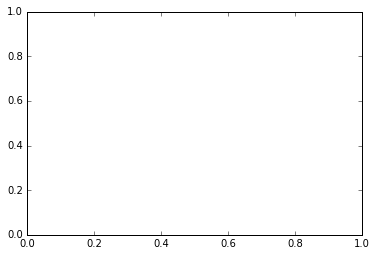

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(tsneXY[posToNegWordList, 0], tsneXY[posToNegWordList, 1])

for i in posToNegWordList:
    ax.annotate(intToWord[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(25, 25)
plt.show()
# notice that we have two very distinct clusters in the embedding as one would expect

Next let's import pre-trained word vectors from google and use them to initialize our embedding to see if this improves the neural net's performance.

In [50]:
from gensim.models import Word2Vec

#get pre trained word2vec from google:
#https://doc-0k-4g-docs.googleusercontent.com/docs/securesc/gnqvgap6hjncpd3b10i2tv865io48jas/hmjtdgee48c14e1parufukrpkb8urra5/1463018400000/06848720943842814915/09676831593570546402/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&nonce=4l49745nmtine&user=09676831593570546402&hash=i2qe9mshan4mesl112ct9bu1tj9kr1hq

googlew2v = Word2Vec.load_word2vec_format('./googleword2vec/GoogleNews-vectors-negative300.bin', binary=True)

ImportError: cannot import name sparsetools

In [51]:
# get word vectors for words in my index
googleVecs = []
for value in range(max_features):
    try:
        googleVecs.append(googlew2v[intToWord[value]])
    except:
        googleVecs.append(np.random.uniform(size=300))

googleVecs = np.array(googleVecs)

print(googleVecs)
print(googleVecs.shape)

[[ 0.23917413  0.15897956  0.8434785  ...,  0.98806871  0.38205706
   0.62928209]
 [ 0.20818576  0.28512894  0.81496149 ...,  0.10549677  0.66347787
   0.5554359 ]
 [ 0.17786342  0.74596074  0.56105008 ...,  0.03089977  0.24301773
   0.1612143 ]
 ..., 
 [ 0.01059982  0.73107178  0.85167182 ...,  0.10719753  0.24103105
   0.96736075]
 [ 0.58931252  0.06267025  0.33400423 ...,  0.78324782  0.42224119
   0.46400115]
 [ 0.21190755  0.53118813  0.54633112 ...,  0.53822338  0.7123129
   0.92488964]]
(10000, 300)


In [52]:
# Bi-directional google

# this example tests if using pretrained embeddings will improve performance 
# relative to starting with random embeddings

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, 300, input_length=max_len, weights=[googleVecs])(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = LSTM(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_google = Model(input=sequence, output=output)
# review model structure
print(model_bidir_google.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 200, 300)      3000000     input_5[0][0]                    
____________________________________________________________________________________________________
batchnormalization_5 (BatchNormal(None, 200, 300)      600         embedding_5[0][0]                
____________________________________________________________________________________________________
lstm_7 (LSTM)                    (None, 64)            93440       batchnormalization_5[0][0]       
___________________________________________________________________________________________

In [53]:
# Bi-directional google

model_bidir_google.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_google = model_bidir_google.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
557s - loss: 0.6557 - acc: 0.5998 - val_loss: 0.4919 - val_acc: 0.7657
Epoch 2/6


KeyboardInterrupt: 

The model with pre-trained word2vec vector's didn't outperform a random embedding, but I suspect it may have if I had run more epochs. Moreover, the number of parameters went up ~3x because the pre-trained vectors were 300d rather than 128d. I suspect I would have had better luck using the glove 6 billion vectors which are 100d instead. Our dataset is just too small to fit a 3 million weight embedding

In [ ]:
test = "I would want to see this movie."

test = imdbTokenizer.texts_to_sequences([test])

from keras.preprocessing import sequence
test = sequence.pad_sequences(test, maxlen=max_len)

test

model_bidir_rmsprop.predict(test)